# 0. Predittore stazione di arrivo

In [17]:
# importo json e request
import json
import requests
import os
import csv
import nltk
import sklearn
import datetime
import time
import random

# apro il dataset grezzo
dataset_piccolo = "small_dataset.csv"
dataset_grande = "big_dataset.csv"
file_name = dataset_grande

# variabili e scelta città
lista_city = [ 'trento', 'rovereto' ]
stazioni = {} # città : stazione : coordinate
all_stazioni = {} # stazione : coordinate
city = 'rovereto'
print("L'utente si trova a: "+city)


# popolo il dizionario con stazioni e coordinate
print("\nCreo struttura:")
for citta in lista_city:
    print("\t"+citta+":")
    stazioni[citta] = {}
    req = requests.get('https://os.smartcommunitylab.it/core.mobility/bikesharing/'+city)
    x = req.json()
    for stazione in x:
        stazioni[citta][stazione['name']] = (stazione['position'][0], stazione['position'][1])
        all_stazioni[stazione['name']] = (stazione['position'][0], stazione['position'][1])
        
        # allineo le coordinate
        tab = "\t\t"
        if len(stazione['name']) > 7:
            tab = "\t"
        if len(stazione['name']) > 15:
            tab = ""
        
        print("\t\t"+stazione['name']+tab+" ("+str(stazione['position'][0])+" - "+str(stazione['position'][1])+")")

L'utente si trova a: rovereto

Creo struttura:
	trento:
		Balista		 (45.896175282432274 - 11.03036572611154)
		Brione		 (45.90421911950808 - 11.044299836454002)
		Lizzana		 (45.8675281353871 - 11.031902417860465)
		Marco		 (45.84133938920707 - 11.008448922615116)
		Mart		 (45.89383120606002 - 11.043776690807363)
		Municipio	 (45.88700893072052 - 11.04421812261512)
		Noriglio	 (45.88365364364294 - 11.070399481792492)
		Orvea		 (45.87202945143379 - 11.020309774135626)
		Ospedale	 (45.88226500641319 - 11.040281016146878)
		P. Rosmini	 (45.89102037579931 - 11.043363036887968)
		Quercia		 (45.90050916437712 - 11.036815184130887)
		Sacco		 (45.88477528345004 - 11.023286167216156)
		Stazione FF.SS.	 (45.89125332494616 - 11.03489086508182)
		Stazione Mori	 (45.861055769357066 - 11.002103832016019)
		Via Paoli	 (45.89177380040726 - 11.039904616532908)
		Villa Lagarina	 (45.91594639958107 - 11.031688259394059)
		Zona Industriale (45.86630335827336 - 11.015673193887324)
	rovereto:
		Balista		 (45

# 1. Creo le varie funzioni

In [18]:
# ***** ------------------
# ***** - Funzioni varie -
# ***** ------------------


print("Funzione latlon()")
# non ricordo mai quale sia latitudine e longitudine:
# questa funzione me lo dice al volo
def latlon(val):
    if 40 < val and val < 50:
        return "lat"
    else:
        return "lon"


print("Funzione rawstr2dict()")
# data una riga (str) dal csv, restituisce uno sgancio o aggancio
def rawstr2dict(stringa):
    # prima suddivisione del dato
    dati = stringa.replace("\"", "").split(",")
    
    # trovo la data
    dataraw = dati[0].split("/")
    oraraw = dati[1].split(":")
    timestamp = datetime.datetime( int(dataraw[2]), int(dataraw[1]), int(dataraw[0]), \
                                   int(oraraw[0]), int(oraraw[1]), int(oraraw[2]) )
    
    # azione (sgancio o aggancio?)
    if dati[2] == '12': # 12 = sgancio, 24 = aggancio
        azione = "sgancio"
        minuti = ''
    else:
        azione = "aggancio"
        minuti = int(dati[5]) # dopo quanto tempo è avvenuto l'aggancio
    
    return {"timestamp":timestamp,
            "azione":azione,
            "stazione":dati[3],
            "minuti": minuti}

print("Funzione creaviaggio()")
# dato un aggancio e sgancio associati, restituisce un viaggio
def creaviaggio(aggancio, sgancio):
    weekday = sgancio['timestamp'].isoweekday()
    # l'ora è il numero di minuti dalle 00:00
    hh = sgancio['timestamp'].hour#*60 + sgancio['timestamp'].minute
    mm = sgancio['timestamp'].hour*60 + sgancio['timestamp'].minute
    partenza = sgancio['stazione']
    arrivo = aggancio['stazione']
    
    return ({"weekday":weekday,
            "hh":hh,
            "mm":mm,
            "lat_partenza": stazioni[city][partenza][0],
            "lon_partenza":stazioni[city][partenza][1],
            "partenza":partenza,
            #"lat_arrivo":stazioni[city][arrivo][0],
            #"lon_arrivo":stazioni[city][arrivo][1]
            },
            arrivo)

print("Funzione classify_n()")
def classify_n(classifier, featureset, n=10):
    
    possibili = classifier.labels()
    dist = classifier.prob_classify( featureset )
    
    punteggi = []
    for s in possibili:
        punteggi.append( (s, dist.prob(s)) )
        
    punteggi.sort(reverse=True, key=lambda tup: tup[1])
    
    return punteggi[0:n]

print("\nFunzione myaccuracy():\n\tAccuratezza calcolata su n tentativi: il classificatore viene\n\tgiudicato sugli n più probabili, dove normalmente n=1\n")
def myaccuracy(classifier, dataset, n=3):
    
    guessed = 0
    
    for data in dataset:
        tentativi = classify_n(classifier, data[0], n)
        risposte = [ s for (s,_) in tentativi ]
        if data[1] in risposte:
            guessed += 1
    
    return guessed/len(dataset)

print("Funzione quantitentativi():\nRestituisce in quanti tentativi il classificatore indovina")
def quantitentativi(classifier, data):
    tried = 0
    tentativi = classify_n(classifier, data[0])
    risposte = [ s for (s,_) in tentativi ]
    tried += risposte.index( data[1] )+1
    return tried

print("\nFunzione nkk_accuracy():\n\tCalcola l'accuratezza del classificatore KNN dato il\n\tparametro k e i pesi per le features")
def knn_accuracy(k=5, hh_weight=0, weekday_weight=0):

    # preparo il dataset
    X = np.array( [ (v['lat_partenza'], v['lon_partenza'], v['mm']*hh_weight, v['weekday']*weekday_weight) for (v,_) in listaviaggi[tr_da:tr_a]] )
    y = np.array( [ target for (_,target) in listaviaggi[tr_da:tr_a]] )
    X_test = np.array( [ (v['lat_partenza'], v['lon_partenza'], v['mm']*hh_weight, v['weekday']*weekday_weight) for (v,_) in listaviaggi[te_da:te_a]] )
    y_test = np.array( [ target for (_,target) in listaviaggi[te_da:te_a]] )
 
    classifier = KNeighborsClassifier(n_neighbors=k)
    classifier.fit(X, y)

    return classifier.score(X_test, y_test)

Funzione latlon()
Funzione rawstr2dict()
Funzione creaviaggio()
Funzione classify_n()

Funzione myaccuracy():
	Accuratezza calcolata su n tentativi: il classificatore viene
	giudicato sugli n più probabili, dove normalmente n=1

Funzione quantitentativi():
Restituisce in quanti tentativi il classificatore indovina

Funzione nkk_accuracy():
	Calcola l'accuratezza del classificatore KNN dato il
	parametro k e i pesi per le features


# 2. Importazione del dataset (sganci e agganci)

In [19]:
# ***** ------------------------
# ***** - Importazione dataset -
# ***** ------------------------


# importo il file
print("Apro il dataset: '"+file_name+"', lo pulisco e divido")
file = open(file_name, "r")
raw = file.read()[1:].replace( "<nobr>","").replace( "</nobr>","") # elimino pezzi inutili
rawsganci = raw.split("\n") # divido per sganci
rawsganci[1].replace("\"", "").split(",")
sganci_all = [rawstr2dict(riga) for riga in rawsganci[1:-1]] # tutti, esclusa la prima riga di intestazione e l'ultima riga vuota


# estraggo solo gli sganci di una città specifica (rovereto)
sganci = []
for x in sganci_all:
    if x['stazione'] in stazioni[city].keys():
        sganci.append(x)

print("\nStruttura:")
print('\ttimestamp:\t',sganci[0]['timestamp'])
print('\tazione:\t\t',sganci[0]['azione'])
print('\tstazione:\t',sganci[0]['stazione'])
print('\tminuti:\t\t',sganci[0]['minuti'])
print("\nTutti gli sganci:\t", len(sganci_all))
print("Sganci di Rovereto:\t", len(sganci))

file_output = open("fout.tsv", "w")
cosa_scrivo = [riga['azione']+"\t"+riga['stazione']+"\t"+str(riga['minuti'])+"\t"+str(riga['timestamp'])+"\n" for riga in sganci_all]
file_output.write("ID\tazione\tstazione\tminuti\ttimestamp\n")
n_id = 1
for i in cosa_scrivo:
    file_output.write(str(n_id)+"\t"+i)
    n_id += 1
    
    
    
    
file_output.close()


Apro il dataset: 'viaggi.csv', lo pulisco e divido

Struttura:
	timestamp:	 2018-04-11 09:12:45
	azione:		 aggancio
	stazione:	 Mart
	minuti:		 5

Tutti gli sganci:	 1134
Sganci di Rovereto:	 1114


# 3. Creo i viaggi

### Spiegazione:
Il dataset fornisce dei record di sganci e agganci (da qui generalmente chiamati 'azioni').
Bisogna prevedere la stazione di arrivo date le caratteristiche della partenza.
Purtroppo, il dataset è incompleto: non sono disponibili tutte le azioni.
Questa parte di codice crea i viaggi cercando coppie sgancio-aggancio compatibili:

N.B. le graffe simboleggiano la durata "all'indietro" del viaggio dall'aggancio

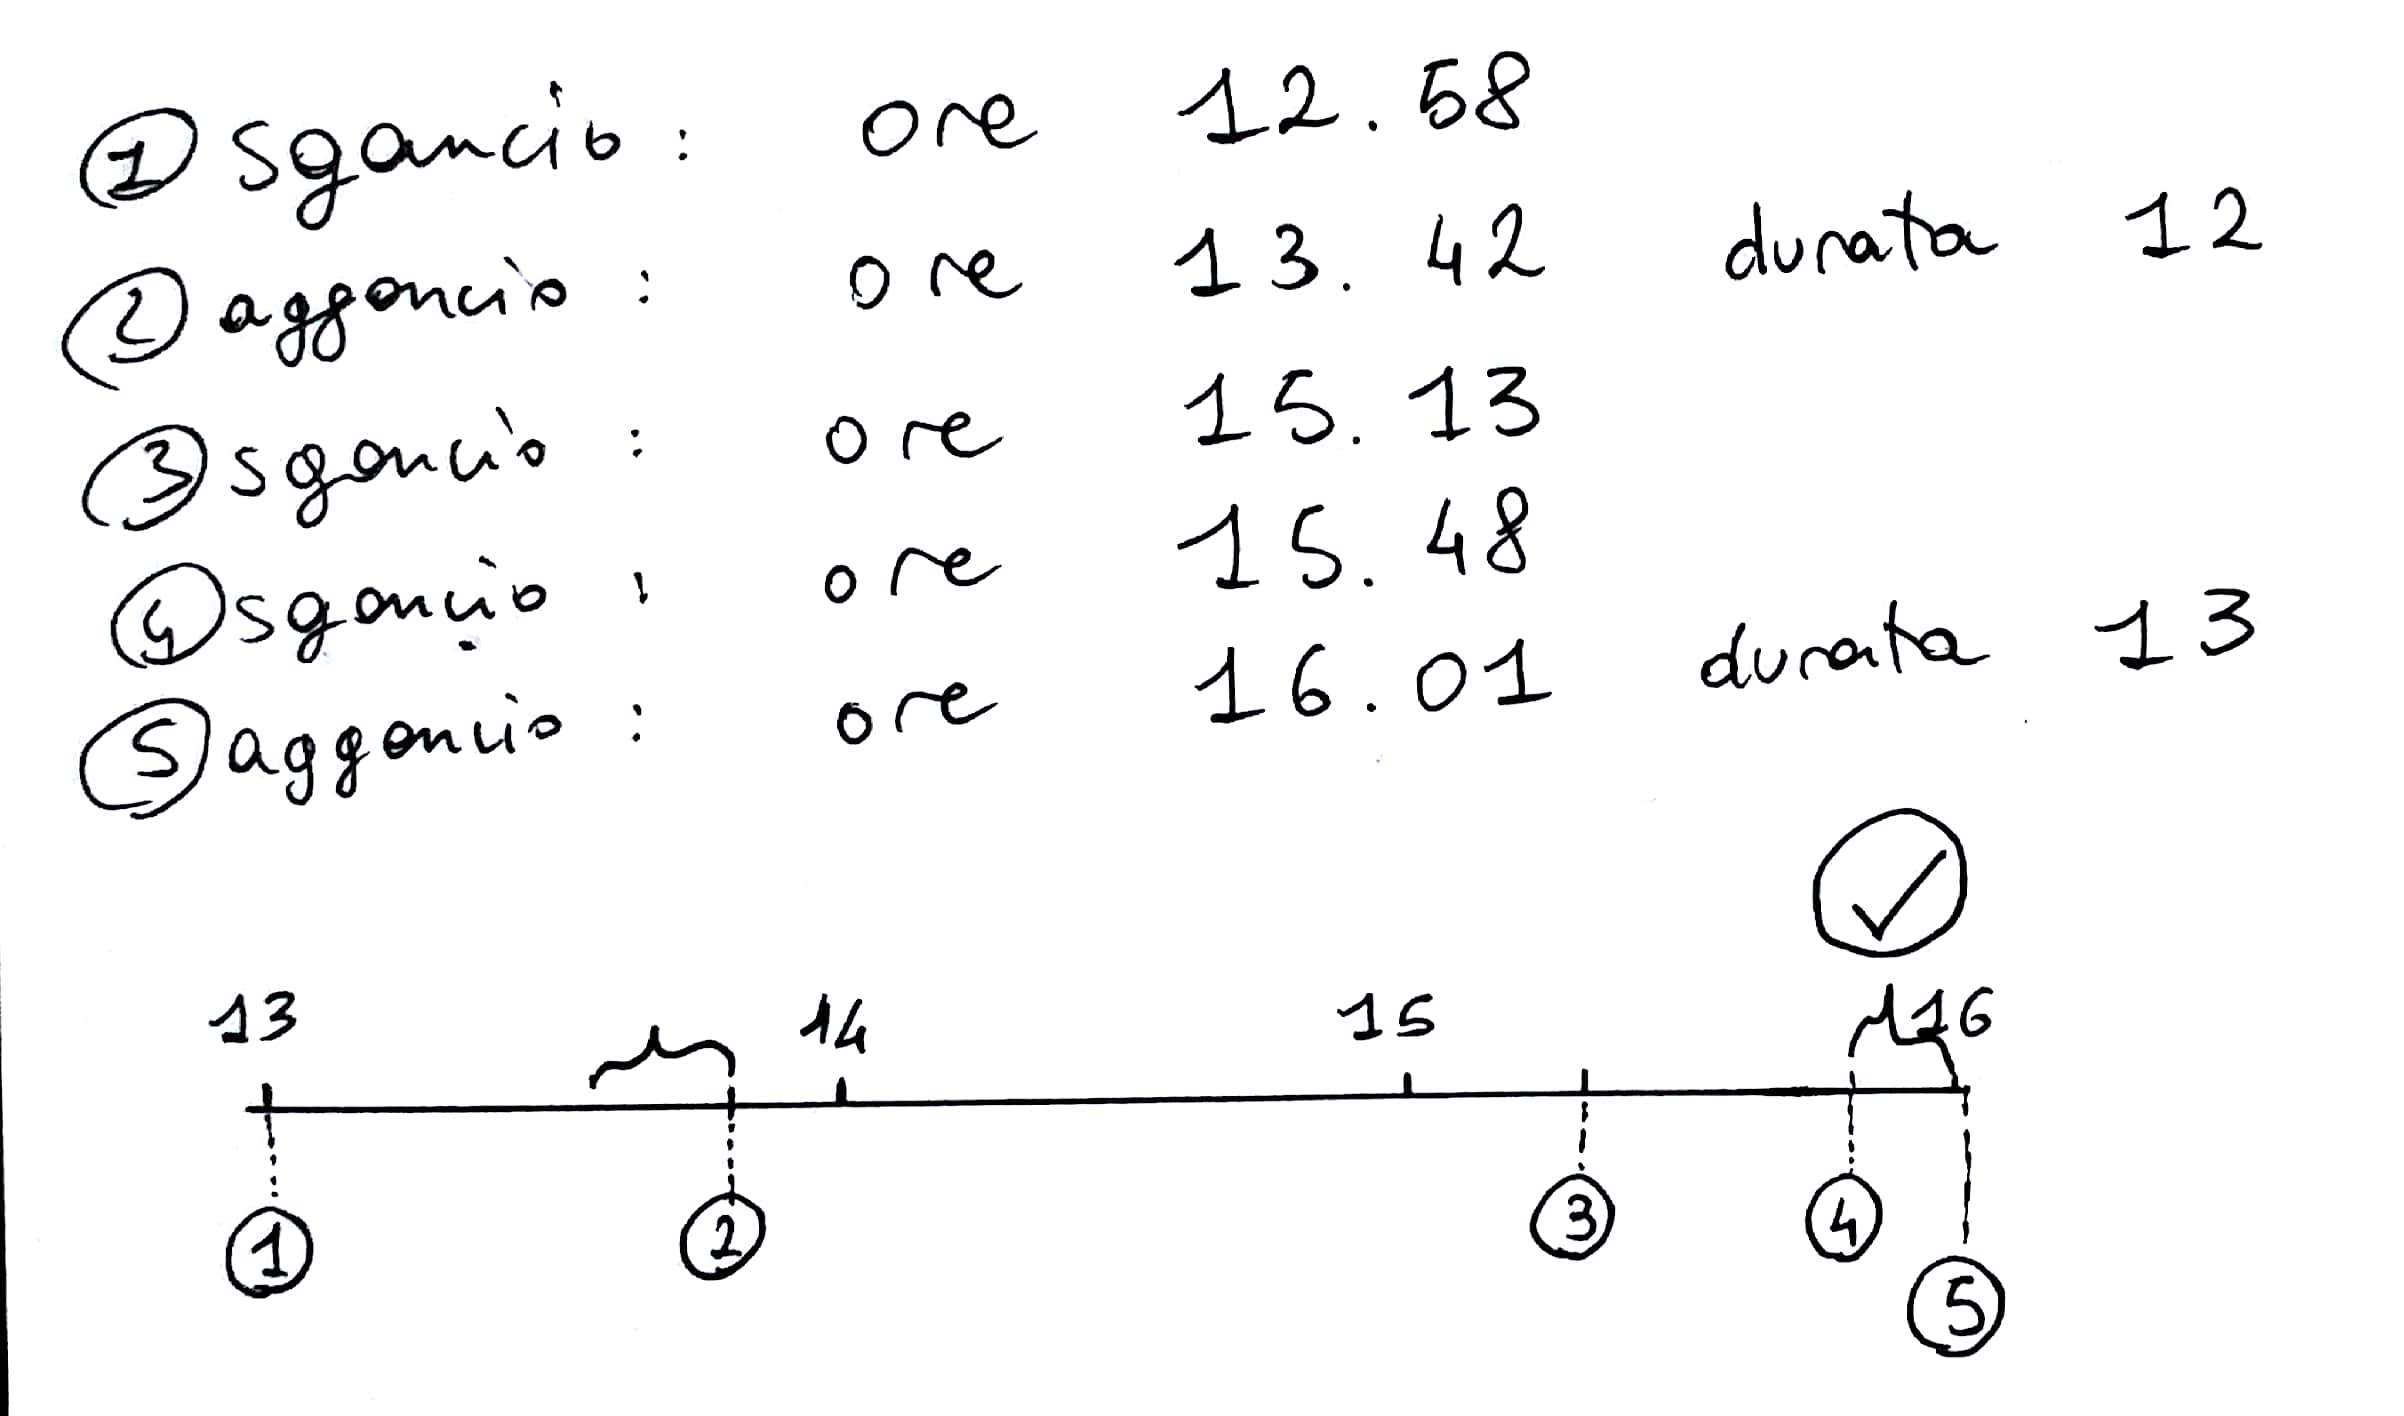

Dall'esempio sopra si evince che:
1. è uno sgancio
2. è un aggancio, ma non può essere associato a (1), è fuori dal range (durata 12 minuti)
3. è uno sgancio
4. è uno sgancio
5. è un aggancio, e può essere associato a (4), è dentro il range (durata 13 minuti)
--> viene quindi creato un viaggio dalle azioni 4 e 5

In [20]:
# creo le variabili e gli indici con i quali scorro
# nel dataset, uno per l'aggancio e uno per lo sgancio
indexA = 0
indexB = 0
count = 0
listaviaggi = []


# scorro tutto il dataset
while( indexA < len(sganci) ):
    # ****************** Per tutte le azioni...
    indexB = indexA + 1
    print("Indici: ", indexA, indexB)
    
    # ****************** Se un'azione è un aggancio
    if sganci[indexA]['azione'] == 'aggancio':
        print(sganci[indexA]['azione'], ":", indexA, "è un aggancio")
        
        # ****************** Prendo il timedelta dell'aggancio
        timedelta = datetime.timedelta( minutes=sganci[indexA]['minuti'] )
        timedelta1min = datetime.timedelta( minutes=1 )
        
        # ****************** Lo sgancio (indexB) corrispondente all'aggancio (indexA)
        # ****************** è la prossima azione il cui timestamp corrisponde al timestamp
        # ****************** dell'aggancio con errore 1minuto (timedelta1min).

        while( sganci[indexB]['timestamp'] > (sganci[indexA]['timestamp'] - timedelta - timedelta1min)  ):
            
            print(indexB, "è maggiore di delta-1")
            if sganci[indexB]['timestamp'] < (sganci[indexA]['timestamp'] - timedelta + timedelta1min):
                print(indexB, "è minore di delta+1")
                print(indexA, "corrisponde con", indexB)
                listaviaggi.append( creaviaggio(sganci[indexA],sganci[indexB]) )
                count += 1
            else:
                print()
                indexB += 1
            break
    
    indexA = indexB
    print("----------------------------")



Indici:  0 1
aggancio : 0 è un aggancio
1 è maggiore di delta-1
1 è minore di delta+1
0 corrisponde con 1
----------------------------
Indici:  1 2
----------------------------
Indici:  2 3
aggancio : 2 è un aggancio
3 è maggiore di delta-1
3 è minore di delta+1
2 corrisponde con 3
----------------------------
Indici:  3 4
----------------------------
Indici:  4 5
aggancio : 4 è un aggancio
5 è maggiore di delta-1
5 è minore di delta+1
4 corrisponde con 5
----------------------------
Indici:  5 6
----------------------------
Indici:  6 7
aggancio : 6 è un aggancio
7 è maggiore di delta-1
7 è minore di delta+1
6 corrisponde con 7
----------------------------
Indici:  7 8
----------------------------
Indici:  8 9
aggancio : 8 è un aggancio
9 è maggiore di delta-1
9 è minore di delta+1
8 corrisponde con 9
----------------------------
Indici:  9 10
----------------------------
Indici:  10 11
aggancio : 10 è un aggancio
11 è maggiore di delta-1
11 è minore di delta+1
10 corrisponde con 11
-

----------------------------
Indici:  103 104
aggancio : 103 è un aggancio
----------------------------
Indici:  104 105
aggancio : 104 è un aggancio
105 è maggiore di delta-1
105 è minore di delta+1
104 corrisponde con 105
----------------------------
Indici:  105 106
----------------------------
Indici:  106 107
aggancio : 106 è un aggancio
107 è maggiore di delta-1
107 è minore di delta+1
106 corrisponde con 107
----------------------------
Indici:  107 108
----------------------------
Indici:  108 109
aggancio : 108 è un aggancio
109 è maggiore di delta-1
109 è minore di delta+1
108 corrisponde con 109
----------------------------
Indici:  109 110
----------------------------
Indici:  110 111
aggancio : 110 è un aggancio
111 è maggiore di delta-1
111 è minore di delta+1
110 corrisponde con 111
----------------------------
Indici:  111 112
----------------------------
Indici:  112 113
aggancio : 112 è un aggancio
113 è maggiore di delta-1
113 è minore di delta+1
112 corrisponde con 

208 è minore di delta+1
207 corrisponde con 208
----------------------------
Indici:  208 209
----------------------------
Indici:  209 210
aggancio : 209 è un aggancio
----------------------------
Indici:  210 211
aggancio : 210 è un aggancio
211 è maggiore di delta-1
211 è minore di delta+1
210 corrisponde con 211
----------------------------
Indici:  211 212
----------------------------
Indici:  212 213
aggancio : 212 è un aggancio
213 è maggiore di delta-1
213 è minore di delta+1
212 corrisponde con 213
----------------------------
Indici:  213 214
----------------------------
Indici:  214 215
aggancio : 214 è un aggancio
215 è maggiore di delta-1
215 è minore di delta+1
214 corrisponde con 215
----------------------------
Indici:  215 216
----------------------------
Indici:  216 217
aggancio : 216 è un aggancio
217 è maggiore di delta-1
217 è minore di delta+1
216 corrisponde con 217
----------------------------
Indici:  217 218
----------------------------
Indici:  218 219
aggan

324 è minore di delta+1
323 corrisponde con 324
----------------------------
Indici:  324 325
----------------------------
Indici:  325 326
aggancio : 325 è un aggancio
326 è maggiore di delta-1
326 è minore di delta+1
325 corrisponde con 326
----------------------------
Indici:  326 327
----------------------------
Indici:  327 328
aggancio : 327 è un aggancio
328 è maggiore di delta-1
328 è minore di delta+1
327 corrisponde con 328
----------------------------
Indici:  328 329
----------------------------
Indici:  329 330
aggancio : 329 è un aggancio
330 è maggiore di delta-1
330 è minore di delta+1
329 corrisponde con 330
----------------------------
Indici:  330 331
----------------------------
Indici:  331 332
aggancio : 331 è un aggancio
----------------------------
Indici:  332 333
aggancio : 332 è un aggancio
333 è maggiore di delta-1
333 è minore di delta+1
332 corrisponde con 333
----------------------------
Indici:  333 334
----------------------------
Indici:  334 335
aggan

430 corrisponde con 431
----------------------------
Indici:  431 432
----------------------------
Indici:  432 433
aggancio : 432 è un aggancio
433 è maggiore di delta-1
433 è minore di delta+1
432 corrisponde con 433
----------------------------
Indici:  433 434
----------------------------
Indici:  434 435
aggancio : 434 è un aggancio
435 è maggiore di delta-1
435 è minore di delta+1
434 corrisponde con 435
----------------------------
Indici:  435 436
aggancio : 435 è un aggancio
436 è maggiore di delta-1
436 è minore di delta+1
435 corrisponde con 436
----------------------------
Indici:  436 437
----------------------------
Indici:  437 438
aggancio : 437 è un aggancio
438 è maggiore di delta-1
438 è minore di delta+1
437 corrisponde con 438
----------------------------
Indici:  438 439
----------------------------
Indici:  439 440
aggancio : 439 è un aggancio
440 è maggiore di delta-1
440 è minore di delta+1
439 corrisponde con 440
----------------------------
Indici:  440 441
-

Indici:  539 540
aggancio : 539 è un aggancio
----------------------------
Indici:  540 541
aggancio : 540 è un aggancio
541 è maggiore di delta-1
541 è minore di delta+1
540 corrisponde con 541
----------------------------
Indici:  541 542
----------------------------
Indici:  542 543
aggancio : 542 è un aggancio
543 è maggiore di delta-1
543 è minore di delta+1
542 corrisponde con 543
----------------------------
Indici:  543 544
----------------------------
Indici:  544 545
aggancio : 544 è un aggancio
545 è maggiore di delta-1
545 è minore di delta+1
544 corrisponde con 545
----------------------------
Indici:  545 546
----------------------------
Indici:  546 547
aggancio : 546 è un aggancio
547 è maggiore di delta-1
547 è minore di delta+1
546 corrisponde con 547
----------------------------
Indici:  547 548
----------------------------
Indici:  548 549
aggancio : 548 è un aggancio
549 è maggiore di delta-1
549 è minore di delta+1
548 corrisponde con 549
-------------------------

----------------------------
Indici:  645 646
----------------------------
Indici:  646 647
aggancio : 646 è un aggancio
647 è maggiore di delta-1
647 è minore di delta+1
646 corrisponde con 647
----------------------------
Indici:  647 648
----------------------------
Indici:  648 649
aggancio : 648 è un aggancio
649 è maggiore di delta-1
649 è minore di delta+1
648 corrisponde con 649
----------------------------
Indici:  649 650
----------------------------
Indici:  650 651
aggancio : 650 è un aggancio
651 è maggiore di delta-1
651 è minore di delta+1
650 corrisponde con 651
----------------------------
Indici:  651 652
----------------------------
Indici:  652 653
aggancio : 652 è un aggancio
653 è maggiore di delta-1
653 è minore di delta+1
652 corrisponde con 653
----------------------------
Indici:  653 654
----------------------------
Indici:  654 655
aggancio : 654 è un aggancio
655 è maggiore di delta-1
655 è minore di delta+1
654 corrisponde con 655
-------------------------

Indici:  751 752
----------------------------
Indici:  752 753
aggancio : 752 è un aggancio
753 è maggiore di delta-1
753 è minore di delta+1
752 corrisponde con 753
----------------------------
Indici:  753 754
----------------------------
Indici:  754 755
aggancio : 754 è un aggancio
755 è maggiore di delta-1
755 è minore di delta+1
754 corrisponde con 755
----------------------------
Indici:  755 756
----------------------------
Indici:  756 757
aggancio : 756 è un aggancio
757 è maggiore di delta-1
757 è minore di delta+1
756 corrisponde con 757
----------------------------
Indici:  757 758
----------------------------
Indici:  758 759
aggancio : 758 è un aggancio
759 è maggiore di delta-1
759 è minore di delta+1
758 corrisponde con 759
----------------------------
Indici:  759 760
----------------------------
Indici:  760 761
aggancio : 760 è un aggancio
761 è maggiore di delta-1
761 è minore di delta+1
760 corrisponde con 761
----------------------------
Indici:  761 762
--------

858 corrisponde con 859
----------------------------
Indici:  859 860
----------------------------
Indici:  860 861
aggancio : 860 è un aggancio
861 è maggiore di delta-1
861 è minore di delta+1
860 corrisponde con 861
----------------------------
Indici:  861 862
----------------------------
Indici:  862 863
aggancio : 862 è un aggancio
863 è maggiore di delta-1
863 è minore di delta+1
862 corrisponde con 863
----------------------------
Indici:  863 864
----------------------------
Indici:  864 865
aggancio : 864 è un aggancio
865 è maggiore di delta-1
865 è minore di delta+1
864 corrisponde con 865
----------------------------
Indici:  865 866
----------------------------
Indici:  866 867
aggancio : 866 è un aggancio
----------------------------
Indici:  867 868
aggancio : 867 è un aggancio
868 è maggiore di delta-1
868 è minore di delta+1
867 corrisponde con 868
----------------------------
Indici:  868 869
----------------------------
Indici:  869 870
aggancio : 869 è un aggancio


aggancio : 966 è un aggancio
967 è maggiore di delta-1
967 è minore di delta+1
966 corrisponde con 967
----------------------------
Indici:  967 968
----------------------------
Indici:  968 969
aggancio : 968 è un aggancio
969 è maggiore di delta-1
969 è minore di delta+1
968 corrisponde con 969
----------------------------
Indici:  969 970
----------------------------
Indici:  970 971
aggancio : 970 è un aggancio
971 è maggiore di delta-1
971 è minore di delta+1
970 corrisponde con 971
----------------------------
Indici:  971 972
----------------------------
Indici:  972 973
aggancio : 972 è un aggancio
973 è maggiore di delta-1
973 è minore di delta+1
972 corrisponde con 973
----------------------------
Indici:  973 974
----------------------------
Indici:  974 975
----------------------------
Indici:  975 976
----------------------------
Indici:  976 977
----------------------------
Indici:  977 978
aggancio : 977 è un aggancio
978 è maggiore di delta-1
978 è minore di delta+1
977

Indici:  1081 1082
----------------------------
Indici:  1082 1083
aggancio : 1082 è un aggancio
1083 è maggiore di delta-1
1083 è minore di delta+1
1082 corrisponde con 1083
----------------------------
Indici:  1083 1084
----------------------------
Indici:  1084 1085
aggancio : 1084 è un aggancio
----------------------------
Indici:  1085 1086
aggancio : 1085 è un aggancio
1086 è maggiore di delta-1
1086 è minore di delta+1
1085 corrisponde con 1086
----------------------------
Indici:  1086 1087
----------------------------
Indici:  1087 1088
aggancio : 1087 è un aggancio
1088 è maggiore di delta-1
1088 è minore di delta+1
1087 corrisponde con 1088
----------------------------
Indici:  1088 1089
----------------------------
Indici:  1089 1090
aggancio : 1089 è un aggancio
1090 è maggiore di delta-1
1090 è minore di delta+1
1089 corrisponde con 1090
----------------------------
Indici:  1090 1091
----------------------------
Indici:  1091 1092
----------------------------
Indici:  1

In [21]:


print( set([ x[1] for x in listaviaggi ]) )

{'Stazione Mori', 'Ospedale', 'P. Rosmini', 'Brione', 'Orvea', 'Municipio', 'Via Paoli', 'Stazione FF.SS.', 'Mart', 'Sacco'}


# 4. Divido il dataset

### Perché in questo modo?
Il mio dataset varia (piccolo/grande): in questo modo fa tutto da solo, data una proporzione da me scelta.

### Ridiamoci su...
Qui avevo scritto male "te_da = tr_a+1" sbagliando il nome della variabile "tr_a": python mi testava quindi l'accuratezza su di un set in gran parte già visto nel set di train. Mi dava un'accuratezza tipo del 95%. Bei momenti.

In [22]:
# creo delle variabili per dividere il dataset
n_viaggi = len(listaviaggi)
decimo_viaggi = int(n_viaggi/5)

tr_da = 0
tr_a = n_viaggi-decimo_viaggi
te_da = tr_a+1
te_a = n_viaggi

print("Train: da",tr_da,"a",tr_a,". Tot:",len(listaviaggi[tr_da:tr_a]))
print("Test: da",te_da,"a",te_a,". Tot:",len(listaviaggi[te_da:te_a]))
print("Totale:",len(listaviaggi[tr_da:tr_a])+len(listaviaggi[te_da:te_a]),"su",n_viaggi)

Train: da 0 a 407 . Tot: 407
Test: da 408 a 508 . Tot: 100
Totale: 507 su 508


# 5. Classificatore Bayesiano

Viaggi: 508

Accuratezza: 0.625
Accuratezza 2: 0.7670000000000001
Accuratezza 3: 0.8780000000000001
Accuratezza 4: 0.9309999999999998
Accuratezza 5: 0.954
Accuratezza 6: 0.968
Accuratezza 7: 0.9789999999999999
Accuratezza 8: 0.99
Accuratezza 9: 0.992
Accuratezza 10: 0.9960000000000001 

Most Informative Features
                partenza = 'Orvea'        Brione : Ospeda =     25.0 : 1.0
                      hh = 9                Mart : Ospeda =     16.3 : 1.0
                      hh = 8                Mart : Ospeda =     12.9 : 1.0
                      hh = 22             Via Pa : Mart   =     11.9 : 1.0
                      hh = 10               Mart : Ospeda =     11.8 : 1.0
                partenza = 'Via Paoli'    Via Pa : Mart   =      7.9 : 1.0
                partenza = 'P. Rosmini'   Ospeda : Mart   =      7.8 : 1.0
                partenza = 'Brione'       Munici : Ospeda =      6.4 : 1.0
                 weekday = 6              Brione : Mart   =      6.4 : 1.0
           

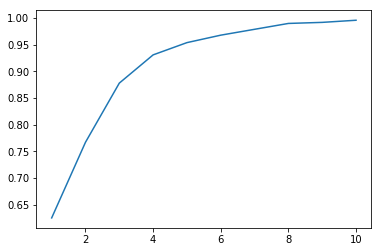

In [23]:
import matplotlib.pyplot as plt
punteggio = 0
my_punteggio2 = 0
my_punteggio3 = 0
my_punteggio4 = 0
my_punteggio5 = 0
my_punteggio6 = 0
my_punteggio7 = 0
my_punteggio8 = 0
my_punteggio9 = 0
my_punteggio10 = 0
runs = 10

# ripeto il test (runs) volte in modo
# da avere una miglior stima dell'accuratezza
# per dataset più piccoli
for x in range(runs): 
    #print(x, "in", runs,)
    for y in range(1000):
        random.shuffle(listaviaggi)

    # "pulisco" i dati: passo esclusivamente partenza e weekday
    train_set = [ ( {'partenza':x['partenza'], 'weekday':x['weekday'], 'hh':x['hh']}, y ) for (x,y) in listaviaggi[tr_da:tr_a] ]
    test_set = [ ( {'partenza':x['partenza'], 'weekday':x['weekday'], 'hh':x['hh']}, y ) for (x,y) in listaviaggi[te_da:te_a] ]
    classifier = nltk.NaiveBayesClassifier.train(train_set)

    punteggio += nltk.classify.accuracy(classifier, test_set)
    my_punteggio2 += myaccuracy(classifier, test_set, 2)
    my_punteggio3 += myaccuracy(classifier, test_set, 3)
    my_punteggio4 += myaccuracy(classifier, test_set, 4)
    my_punteggio5 += myaccuracy(classifier, test_set, 5)
    my_punteggio6 += myaccuracy(classifier, test_set, 6)
    my_punteggio7 += myaccuracy(classifier, test_set, 7)
    my_punteggio8 += myaccuracy(classifier, test_set, 8)
    my_punteggio9 += myaccuracy(classifier, test_set, 9)
    my_punteggio10 += myaccuracy(classifier, test_set, 10)
    
accuratezza_media = punteggio / runs
my_accuratezza_media2 = my_punteggio2 / runs
my_accuratezza_media3 = my_punteggio3 / runs
my_accuratezza_media4 = my_punteggio4 / runs
my_accuratezza_media5 = my_punteggio5 / runs
my_accuratezza_media6 = my_punteggio6 / runs
my_accuratezza_media7 = my_punteggio7 / runs
my_accuratezza_media8 = my_punteggio8 / runs
my_accuratezza_media9 = my_punteggio9 / runs
my_accuratezza_media10 = my_punteggio10 / runs

print("Viaggi:", len(listaviaggi))
print("\nAccuratezza:",accuratezza_media)
print("Accuratezza 2:",my_accuratezza_media2)
print("Accuratezza 3:",my_accuratezza_media3)
print("Accuratezza 4:",my_accuratezza_media4)
print("Accuratezza 5:",my_accuratezza_media5)
print("Accuratezza 6:",my_accuratezza_media6)
print("Accuratezza 7:",my_accuratezza_media7)
print("Accuratezza 8:",my_accuratezza_media8)
print("Accuratezza 9:",my_accuratezza_media9)
print("Accuratezza 10:",my_accuratezza_media10,"\n")

# ************************************************* #
# Sì, lo so, ma non avevo voglia di fare un for...  #
# ************************************************* #

plt.plot( [1,2,3,4,5,6,7,8,9,10], [accuratezza_media,my_accuratezza_media2,my_accuratezza_media3,my_accuratezza_media4,my_accuratezza_media5,my_accuratezza_media6,my_accuratezza_media7,my_accuratezza_media8,my_accuratezza_media9,my_accuratezza_media10] )

classifier.show_most_informative_features(20)

## ## ## SENZA HH
## dataset piccolo :      Viaggi: 77
##                   Accuratezza: 0.5484999999999998

## dataset grande :       Viaggi: 508
##                   Accuratezza: 0.6089723320158099

## ## ## CON HH
## dataset piccolo :      Viaggi: 77
##                   Accuratezza: 0.5948333333333331

## dataset grande :       Viaggi: 508
##                   Accuratezza: 0.6529591836734656

### Osservazioni:
1. Se sono le 17 è molto più probabile che vada a casa, piuttosto che in uni
2. Se parto da 'Via Paoli' è più probabile che vada dal collega che abita vicino ad 'Ospedale'
3. Se parto dal 'Mart', è molto probabile che vada in 'Stazione'
4. Come per il punto (1), alle 18 di solito vado a casa
5. Se parto dalla 'Stazione', di solito vado al 'Mart', ma se la stazione è piena mi fermo in 'P. Rosmini'

# 6. Provo a usare KNN

### Perché no
Purtroppo, le dimensioni delle features sono molti ordini di grandezza differenti. Basti pensare all'ora, in cui una differenza di un'unità corrisponde ad un minuto, e alle coordinate, in cui un'unità corrisponde a decine di chilometri!

Risulta difficile e dispendioso trovare un coefficiente con il quale pesare le features, anche considerando che il tutto dovrà funzionare su di uno smartphone.

Ho voluto comunque provare, visto che questo algoritmo permette di usare features continue, a differenza di Bayes che ne ammette solamente di discrete.

Ho provato a far variare in serie i vari pesi. A una certa ho rinunciato, venivano comunque risultati migliori con Bayes, ma ho comunque lasciato un pezzo del codice qui sotto.

In [42]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier, kneighbors_graph
from sklearn import preprocessing 

import matplotlib.pyplot as plt
%matplotlib inline

for y in range(100):
    random.shuffle(listaviaggi)

krisultati = [ knn_accuracy(k) for k in range(1,50) ]
kbest = krisultati.index(max(krisultati)) +1

# normalizzo
listaviaggi_normalizzata = listaviaggi

def normalize_listaviaggi_features(feature):
    array_da_normalizzare = [val[0][feature] for val in listaviaggi]
    xmin = min(array_da_normalizzare)
    xmax = max(array_da_normalizzare)
    
    for i in range(len(listaviaggi)):
        listaviaggi_normalizzata[i][0][feature] = ( (array_da_normalizzare[i]-xmin)/(xmax-xmin) )

lista_features_da_normalizzare = ['lat_partenza', 'lon_partenza', 'mm', 'weekday']
for feature in lista_features_da_normalizzare:
    normalize_listaviaggi_features(feature)

# testo il classificatore
X = np.array( [ (v['lat_partenza'], v['lon_partenza'], v['mm'], v['weekday']) for (v,_) in listaviaggi[tr_da:tr_a]] )
y = np.array( [ target for (_,target) in listaviaggi[tr_da:tr_a]] )
X_test = np.array( [ (v['lat_partenza'], v['lon_partenza'], v['mm'], v['weekday']) for (v,_) in listaviaggi[te_da:te_a]] )
y_test = np.array( [ target for (_,target) in listaviaggi[te_da:te_a]] )
 
classifier = KNeighborsClassifier(n_neighbors=kbest)
classifier.fit(X, y)
classifier.score(X_test, y_test)

0.7

# 6.B Provo a usare KNN, ma prima normalizzo

0.57


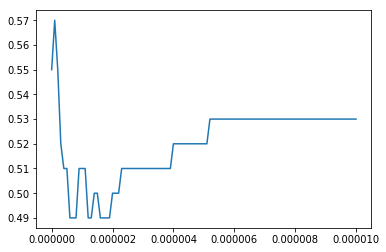

Best: wd = 0.0 0.57 6


In [26]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier, kneighbors_graph

import matplotlib.pyplot as plt
%matplotlib inline

for y in range(100):
    random.shuffle(listaviaggi)

accuratezza_media_knn = 0
for z in range(10):
    krisultati = [ knn_accuracy(k) for k in range(1,50) ]
    kbest = krisultati.index(max(krisultati)) +1

    mmscore = 0
    n10 = 3
    myrange = np.arange(0, 10**-n10, 10**-(n10+2))
    mmrisultati = [ knn_accuracy(kbest, mm) for mm in myrange ]
    mmscore = max(mmrisultati)
    mmbest = mmrisultati.index(max(mmrisultati))*10**-(n10+2)

    wdscore = 0
    wdbest = 0
    n10 = 1
    while ((wdscore <= mmscore) and (n10 < 15)):
        myrange = np.arange(0, 10**-n10, 10**-(n10+2))
        wdrisultati = [ knn_accuracy(kbest, mmbest, wd) for wd in myrange ]
        wdscore = max(wdrisultati)
        wdbest = wdrisultati.index(max(mmrisultati))*10**-(n10+2)
        n10 += 1
    accuratezza_media_knn += wdscore

print(wdscore)

wdscore = 0
wdbest = 0
n10 = 1
while ((wdscore <= mmscore) and (n10 < 15)):
    myrange = np.arange(0, 10**-n10, 10**-(n10+2))
    wdrisultati = [ knn_accuracy(kbest, mmbest, wd) for wd in myrange ]
    wdscore = max(wdrisultati)
    wdbest = wdrisultati.index(max(mmrisultati))*10**-(n10+2)
    n10 += 1

plt.plot( myrange, wdrisultati )
plt.show()

print("Best: wd =", wdbest, wdscore, n10)

# 7. Faccio qualche esperimento con la funzione polyfit

### Perché?
Sarebbe interessante creare il proprio algoritmo Bayesiano che ricavi la probabilità da una funzione continua.

<function matplotlib.pyplot.show>

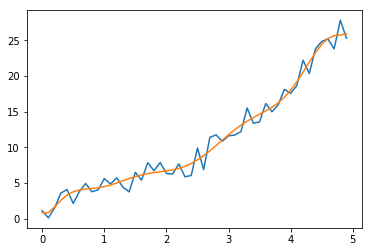

In [27]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import *
%matplotlib inline

x = np.arange(0,5,0.1)
y = [ value**2+(np.random.rand(1)*5) for value in x ]

p1 = np.polyfit(x,y,10)
x_prev = np.polyval(p1,x)

plt.plot(x,y)
plt.plot(x,x_prev)

plt.show

['Stazione Mori', 'Ospedale', 'P. Rosmini', 'Brione', 'Orvea', 'Municipio', 'Via Paoli', 'Stazione FF.SS.', 'Mart', 'Sacco']


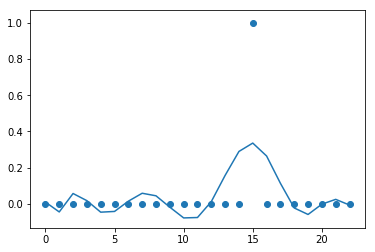

In [28]:
possibili = [x for x in set( [y for (_,y) in listaviaggi] ) ]
stazione_scelta = possibili[4] # oppure 4

mm_range = np.arange(0, (24*60), 1)
mm_y = [0 for mm in mm_range]

delta = 30

for mm in mm_range:
    mm_y[mm-1] = len( [x for (x,y) in listaviaggi if x['mm'] < mm+delta and x['mm'] > mm-delta and y == stazione_scelta] )
    
hh_range = np.arange(0,23,1)
hh_y = [0 for hh in hh_range]

for hh in hh_range:
    hh_y[hh-1] = len( [x for (x,y) in listaviaggi if x['hh'] == hh and y == stazione_scelta] )
    
p1 = np.polyfit(hh_range,hh_y,10)
x_prev = np.polyval(p1,hh_range)

#plt.scatter(mm_range,mm_y)
plt.scatter(hh_range,hh_y)
plt.plot(hh_range,x_prev)

print(possibili)

In [29]:
import pandas as pd

df = pd.read_csv("fout.tsv", sep="\t", index_col=0)
df.head()

,azione,stazione,minuti,timestamp
ID,,,,
1,aggancio,Mart,5.0,2018-04-11 09:12:45
2,sgancio,Ospedale,NaN,2018-04-11 09:07:13
3,aggancio,Ospedale,9.0,2018-04-10 18:58:16
4,sgancio,P. Rosmini,NaN,2018-04-10 18:49:42
5,aggancio,P. Rosmini,7.0,2018-04-10 09:01:27


# 8. Proviamo a fare la PCA

In [30]:
# importo
def doPCA():
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    pca.fit(data_pca)
    return pca

data_pca = []

for viaggio in listaviaggi:
    el = [
        viaggio[0]['hh'],
        viaggio[0]['lat_partenza'],
        viaggio[0]['mm'],
        viaggio[0]['lon_partenza'],
        viaggio[0]['weekday']
    ]
    
    data_pca.append(el)

pca = doPCA()

In [31]:
print(pca.explained_variance_ratio_)
first_pc = pca.components_[0]
second_pc = pca.components_[1]

[0.99665854 0.00226375]


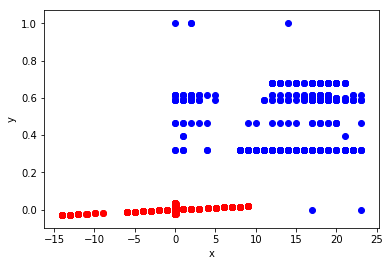

In [32]:
transformed_data = pca.transform(data_pca)
for ii, jj in zip(transformed_data, data_pca):
    plt.scatter(first_pc[0]*ii[0], first_pc[1]*ii[0], color="r")
    plt.scatter(second_pc[0]*ii[0], second_pc[1]*ii[1], color="r")
    plt.scatter(jj[0], jj[1], color="b")
    
plt.xlabel("x")
plt.ylabel("y")
plt.show()